In [2]:
%load_ext tikzmagic

# Discrete Time Stochastic Control Processes in Macroeconomics

This notebook discusses the mathematics of dynamic stochastic optimization problems as used in macroeconomics.

The goal of this work is to systematize the mathematics used in economic modeling, starting with dynamic stochastic optimization problems in microeconomics and building towards heterogeneous agent models (HAM) of partial or general equilibria. This will also explore the ways these models can be used for population simulation with the birth and death of agents.

This works aims to bridge the mathematical models from macroeconomics to classes of processes defined in computer science and more general engineering disciplines. In these other disciplines, the formal complexity properties of these processes are well studied, and often there are already tools available for computional estimation and/or execution of these processes. If these connections can be made, it stands to reason that they would likely helpfully inform the design of Econ-ARK, a software toolkit for structural modeling of HAMs.

The main contributions of this work so far are:
 - A formalization of Bellman form structural equation models, BFSEM
 - Proof that a BFSEM to an MDP.
 - **TO DO: Generalized backwards induction techniques for BFSEMs with multiple control variables.**



## Microeconomic dynamic stochastic optimization problems

We begin with a discussion of microeconomic dynamic stochastic optimization problems (Micro-DSOP). We will use Carroll (2020) as a point of reference. 

### Example: idiosyncratic income shocks model

Here is a simple example of such a problem, the idiosyncratic income shock model. The consumer controls their consumption $c$ at each time step and gets utility $u(c)$ each period that they consumer. The consumer consumes out of a stock of resources $m$ that is replenished by income. The consumer receives two income shocks at the beginning of each period: a completely transitory shock $\theta$ and a completely permanent shock $\psi$.  Moreover, the agent is subject to borrowing a borrowing limit: the ratio of end-of-period assets $A_t$ to permanent income $P_t$ must be greater than $\text{$\underline{a}$}$.  As with the perfect foresight problem, this model is stated in terms of *normalized* variables, dividing all real variables by $P_t$:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} {~} u(c_t) + \beta (1- D_{t+1})  \mathbb{E}_{t} \left[ (\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) \right], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \text{$\underline{a}$}, \\
m_{t+1} &=& R /(\Gamma_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
(\psi_{t+1},\theta_{t+1}) &\sim& F_{t+1}, \\
\mathbb{E}[\psi]=\mathbb{E}[\theta] &=& 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

This problem can be solved by determining $v_t$ for all possible $m_t$ through dynamic programming, and the $c$ corresponding to that $v_t$. The optimal consumption function $\pi(m)$ is the optimal _decision rule_ for the problem.

This is a specific instance of a broader class of processes. A question we can ask is: what, broadly, is the class of processes to which this problem belongs? How can we characterize that class efficiently such that we can propose techniques for solving them more generally?


### Generalizing to Bellman form structural equation models

The form of the idiosyncratic income shock model above is the Bellman form of the problem. This is a rendering of the problem that makes it amenable to dynamic programming. However, this form compresses how the problem can be seen as consisting of several mathematically distinct elements. What follows are observations about this example which generalize across other problems in this space, and to the theory of dynamic programming more generally.

First, note that $t$ is used as a subscript or index over many of the other variables in the model. Following convention, we will refer to $t$ sometimes as "time".

Second, note that the value function $v_t$ is highly compressed. It is an analytic reduction of the true Bellman Form of the problem, which defines the value of a state as the maximum, over all the control variables, of the utility at this time period plus the recursively discounted utility at the next period.

$$v_t(m_t) = max_{c_t} u(c_t) + \beta \mathbb{E}_{t} \left[ v_{t+1}(m_{t+1}(c)) \right]$$

Here, we have turned $m$ into a function of $c$, though this depends on our understanding that $m_{t+1}$ is a stochastic function that depends on all of the transition equations and conditions of the problem formulation above.

Third, the maximization term in the definition of $v_t$ is over one particular variable of interests, in this case consumption $c$. This is the control variable or action variable of the agent. The fact that it is positioned here, under the maximization term, distinguishes it as the variable over which the agent must optimize. 

Fourth, there are several other variables including the domain of $v$ and random variables that are connected to the control variable $c$ via several equations and conditions. We we call these variables _model variables_ and the equations and conditions _structural equations_.

We are still far from general theory. What we have are the following terms:
 * a time index $t$
 * a set of _model variables_, which includes a _control variable_
  * a value function $v$:
    - whose domain is defined in terms of model variables
    - which is a maximization over the control variable
    - is recursively defined in terms of the time index

This structure suggests that the problem is a special case of a _discrete time stochastic control process_. The integral time index $t$ is _discrete time_. The problem is a _control process_ because the question is how to optimally set the control variable in each discrete time step in order to maximize some value function. It is _stochastic_ because some of the model variables are random variables.

Perhaps because of the disciplinary distance between economics and the control theory that defines a _discrete time stochastic control process_, it is not immediately obvious how these kinds of models, which I will call _Bellman form structural equation models_ (BFSEM), relate to the more general control theory.

## MDP : Dynamic stochastic decision problems in general

It can be difficult to find a general characterization of a discrete time stochastic control process. One of the best known is that Markov Decision Process (MDP). An MDP is defined as a four-tupe $(S, A, P_{a}, R_{a})$, where:
 - S is a set called the _state space_
 - A is a set called the _action space_
 - $P_a(s, s') = Pr(s_{t+1} = s' | s_t = s, a_t = a)$, for $s, s' \in S$ and $a \in A$ is the probability that action $a$ in in state $s$ at time $t$ will lead to state $s'$ in period $t+1$
 - $R_a(s, s')$ is the reward to the agent for transitioning from $s$ to $s'$ with action $a$.
 
The objective is to choose a the best policy function $\pi: S \rightarrow A$ that maximizes
 
$$\mathbb{E}[\sum^\infty_0 \beta R_{\pi(s)}(s, s')]$$
 
for a discount factor $0 \leq \beta \leq 1$.
 
MDP's are amenable to the Bellman form transformation. The problem can be framed as determining the optimal parameter defined in terms of a value function. Define the value function of a policy $\pi$ as:
 
$$V^{\pi}(s_0) = \mathbb{E}[\sum^\infty_0 \beta R_{\pi(s)}(s, s')]$$
 
which can be defined recursively as
 
$$V^{\pi}(s) = \mathbb{E}[R_{\pi(s)}(s, s')] + \beta \mathbb{E}_{Pr(s' | s, \pi(s))}[V^{\pi}(s')]$$
 
The optimal value function is then:
 
$$V^*(s) = \max_{\pi} V^{\pi}(s)$$

This is the most general form of the discrete time stochastic control process available.

Note that:
 - Time $t$ is a structural element of the optimization problem itself, not a member of the sets S or A.
 - The transition function $P$ is stochastic and relates $s_t$, $a_t$ and $s_{t+1}$
 - The optimal policy or "decision rule" is a function from states to actions.

## Connecting BFSEMs with MDPs

While in some of our discussions it has been presumed that BFSEMs are a special case of MDPs, it is not immediated obvious that this is the case. For one thing, BFSEMs have not yet been given a generic mathematical form. Then again, it has not been shown that for every BFSEMs, there exists an equivalent MDP. This is the work of this section.

### Formalizing the BFSEM

Let a BFSEM be a tuple $(\mathcal{S}, C, E, U)$ where:
 - $\mathcal{S}$ is a set of model state variable; each model variable may be indexed by the natural number $t$, called _time_ by convention
 - $C$ is a set of maodel control variables
 - $E$ is a set of equations and or inequalities between temporally indexed model variables.
    - These equations (or inequalities) must have a single model state variable $s \in \mathcal{S}$, indexed at $t$ on the left hand side
    - These equations (or inequalities) may have formulas on the right hand side containing:
      - constants
      - random distributions (i.e, $Normal(0,1)$)
      - model state variables $s \in \mathcal{S}$ indexed to time $t$ or $t-1$.
      - model control variables $c \in C$ indexed to time $t$ or $t-1$.
      - mathematical compositions of the previous terms.
 - $U: dom(C) \times dom(\mathcal{S}) \rightarrow \mathbb{R}$ is a utility function
     - utility is awarded to the agent each period based on $M_t$.

The utility function gets evaluated once per time period. The agent seeks to optimize their utility over time given the transitions specified by the structural equations $E$.

A decision rule $\pi$ is used each period to determine the value of each control variable.
The model variables in each time step are determined by the structural equations and the model variables, including the choice of control variabels, in the previous time step.

Control variables are determined by a decision rule or policy $\pi$.

$$s_t = E(\mathcal{s}_{t-1}, c_{t-1})$$

$$c_t = \pi(s_t, s_{t-1})$$

Together these determine $m_t$ for all $t$. (This is for an infinite horizon model. An initial state for the model states is optional). The agent seeks to optimize their discounted utility over time:

$$\sum^\infty_{t = 0} \beta ^ t \mathbb{E} [U(m_t)]$$

This becomes the basis of optimizing their decision rule $\pi$.

There are many complications latent within this formalization of the model. To be complete, this formalization would need to include many conditions that prevent, for example, a policy determining a control variable from depending on a state variable that depends on it in the same time period. It is also difficult to ensure that the utility function is tracking the same state values as determined by stochastic structural equations.

We will work out these details later. This current BFSEM formalization should be thought of as incomplete, a working draft, as we try to bring these models into alignment with more general work on decision and control theory.

### Mapping to the MDP

There is clearly a resonance between the BFSEM formalism $(\mathcal{S}, C, E, U)$ above and the MDP formalism $(S, A, P_{a}, R_{a})$.

Roughly speaking, in both formalisms there is a time parameter $t$, state that varies over time $\mathcal{S}$ and $S$; a field of agency control $C$ or action $A$; a determination of the state values in the future based on the state and actions in the present, either as structural equations $E$ or a probability distribution $P$; and a determination of the value awarded to the agent in each time step $U$ or $R$.

However, the two formalisms are not identical. Most notably, the probability distribtion $P$ and the structural equations $E$ are different forms of mathematical entities. This key difference in the two formalisms leads to other subtle differences in the models.

We consider the following proposition:

`Proposition 1. For every well-formed BFSEM, there exists an equivalent MDP.`

This proposition is not yet fully specified. By "well-formed", we mean adhering to the currently miscellaneous constraints suggested at the end of the previous section. By "equivalent" we mean something like: the models are isomorphic; the decision rules for the BFSEM can be transformed to decision rules for the MDP by a bijection; and the optimal decision rule for the BFSEM and for the MDP will have the same discounted expected utility for the agent. Fleshing out the specifics of this proposition is work that remains to be done.

We will prove Proposition 1, or some better specified variation of it, by construction. In roder to do so, we will need to inspect and compare the two formalisms more carefully.

First, consider the model states. $S$ for the MDP and $\mathcal{S}$ for the BFSEM have been given different fonts lest they be confused. Indeed, the notation here can be confusing! In the MDP, $S$ is the set of all possible values of the model state at time $t$. In the BFSEM, $\mathcal{S}$ is the set of all of the model state variables. The latter is perhaps underspecified, because the model state variables have not been given domains. But we can see that whereas $m$, the market resources available to the agent, can be a member of the set $\mathcal{S}$, it cannot be a member of the set $\mathcal{S}$, which is a set of state _values_, not state _variables_.

In the idiosyncratic shock model used as an example above, $\mathcal{S} = (m, a, \psi, \theta, \Gamma)$. Each of these variables ranges over the real numbers $\mathbb{R}$. Therefore, the state _space_ of the model $S$ is $\mathbb{R}^5$.

Likewise, the idiosyncratic shock BFSEM control variables are $C = {c}$, but the value of the variable $c$ ranges over $\mathbb{R}$, and so the action space $A = \mathbb{R}$.

Once this transformation is made, it becomes easier to see the correspondence between the BFSEM and MDP. The variable notation used in the BFSEM can now be used as a way of organizing the representation of the MDP state and action space, giving each dimension of state and action a name. This is helpful when specifying the transition and reward functions $P$ and $R$. This also reveals that for a BFSEM, each variable in $\mathcal{S}$ and $C$ must be given a domain.

As for the utility and reward functions $U$ and $R$, it is now easier to map their equivalence. $R: A \times S \times S \rightarrow \mathbb{R}$. $U: dom(C) \times dom(\mathcal{S}) \rightarrow \mathbb{R}$. Since $A = dom(C)$ and $S = dom(\mathcal(S))$, it is clear that for any $U$, an equivalent $R$ can be constructed such that its third term is irrelevant to its output. MDPs provide additional expressive range to the reward function which is not needed by BFSEMs.

This leaves the question of mapping between the structural equations $E$ and the probability distribution $P$.

### Structural Equation Models and Probability Distributions

***The relationship between structural equations $E$ and probability distributions $P$. This relationship has been very well explored by Judea Pearl (e.g. 1998, 2009). However, I am unaware of any work that has adapted the Pearlian treatment of structural equation models to dynamic stochastic control. There is a small chance that this is a new idea. There is a greater chance that this is a new idea "within economics" but one that is already addressed in the vast engineering literature. Based on my work with macroeconomists so far, it sounds like these results are not yet considered "obvious" to their field. I wonder if they are publishable.***

A key contribution of Pearl (1998, 2009) is that there is a mathematical correspondence between structural equation models and probabilistic graphical models, and that this correspondence can be used to give precision to many ideas about causal reasoning in the social sciences.

A set of structural equations, each determining one variable on the left hand side, induces a [partial ordering](https://en.wikipedia.org/wiki/Partially_ordered_set#:~:text=Formally%2C%20a%20partial%20order%20is,the%20end%20of%20the%20chain) on the model variables. These variables can be arranged into a directed acyclic graph (DAG) such that a directed edge $(u,v)$ exists if and only if $u$ appears in the right hand side of the equation for variable $v$. The graph then depicts the dependency relations between the variables.

This is a DAG representing the idiosyncratic shock problem used above.

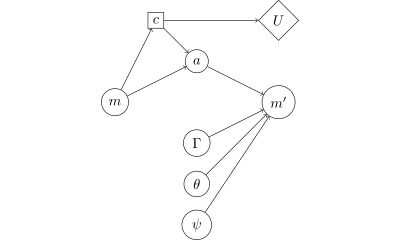

In [15]:
%%tikz -f svg
\usetikzlibrary{shapes}

\node[shape=circle,draw=black] (m) at (0,4) {$m$};

\node[shape=rectangle,draw=black] (c) at (1,6) {$c$};

\node[shape=circle,draw=black] (a) at (2,5) {$a$};

\node[shape=circle,draw=black] (gamma) at (2,3) {$\Gamma$};
\node[shape=circle,draw=black] (theta) at (2,2) {$\theta$};
\node[shape=circle,draw=black] (psi) at (2,1) {$\psi$};

\node[shape=circle,draw=black] (m_) at (4,4) {$m'$};
\node[shape=diamond,draw=black] (U) at (4,6) {$U$};

\path [->] (m) edge node[left] {} (c);

\path [->] (c) edge node[left] {} (U);
\path [->] (c) edge node[left] {} (a);
\path [->] (m) edge node[left] {} (a);
                                              
\path [->] (a) edge node[left] {} (m_);

\path [->] (gamma) edge node[left] {} (m_);
\path [->] (theta) edge node[left] {} (m_);
\path [->] (psi) edge node[left] {} (m_);

When some of the variables are random variables (as are $\theta$ and $\psi$ here), the entire graph structure becomes a _probabilistic graphical model_. _Each_ variable represents a random variable whose value is conditional on it parents $Pa(\cdot)$ in the graph.

The conditional probability distribution at each node also determines the joint probability. For a set of variables $\mathcal{X} = X_1, X_2, X_3, ...$, and a function $Pa(\cdot)$ given by the DAG structure $G$, 

$$P(\mathcal{X}) = \prod_{X \in \mathcal{X}} P(X | Pa(X))$$

This procedure is the general way in which the structural equations $E$ from a BFSEM can be transformed into a transition probability distribution $P$ as per an MDP.

There are a few details to work out here.

Recall that in the MDP definition, $P_a(s, s') = Pr(s_{t+1} = s' | s_t = s, a_t = a)$.

This can be derived from the joint probability distribution $P(\mathcal{S}' | \mathcal{S}, C)$ derived as above from the structural equations $E$.

$$Pr(\mathcal{S}' | \mathcal{S} = \hat{S}, C = \hat{C}) = \prod_{s' \in \mathcal{S}'} Pr(s' | Pa(s') \in (\hat{S}, \hat{C}))$$

Note how the control variables $C$ are given in this equation. They are treated similarly to the state variables for the purpose of computing the joint distribution. This elides how they are structurally distinct in the model for the purposes of defining the optimization problem.

### The policy $\pi$

The essential feature of both MDPs and BFSEMs is that they are control/optimization problems, raising the question of how an agent can perform optimally given limited control over the system. As noted, $A = dom(C)$ for the purpose of drawing an equivalence between an MDP and a BFSEM. But what does that mean for the policy $\pi$?

In the MDP, a policy is a function $\pi: S \rightarrow A$ from states to actions. Once the policy is determined, the system can be forward simulated as follows:
 - Starting in state $s \in S$, determine action $a = \pi(s)$
 - Determine next state $s' ~ Pr(s' | s, a)$
 - Repeat with $s = s'$
 
In a BFSEM, it is a little more complicated because the action space is in principle broken up into distinct control variables, and these control variables can be ordered within a period by virtue of how they are used in the structural equations $E$. Indeed, the modeler may wish to constrain the information available to the agent at each point of control separately.

It may be best, therefore, to introduce the following constraint as part of what it means to be a "well-formed" BFSEM:

 - Each control variable $c \in C$ has a defined set of parents $Pa(c)$.
     - Example: In the idiosyncratic shock case, $Pa(c) = \{m\}$
 - A _decision rule_ for a variable $v$, $\delta_v$, is a function of the values of the parents of $v$. I.e., $\delta_v: dom(Pa(v)) \rightarrow v$.
     - in a more general formulation, $\delta$ would be a probability distribution rather than a deterministic function.
 - A complete _policy_ for a BFSEM is a set of decision rules for all control variables, i.e. $\pi_v = \delta_v$.
 
In the graphical model above, the consumption variable $c$ was depicted with a square instead of a circle; that was to denote that it is a control variable. A policy $\pi$ and an SFSEM _induces_ a joint distribution over all variables $\mathcal{S}', \mathcal{S}, C)$ in a time-recurring way which also preserves the structural dependency relations between the individual variables.

## Next steps

There are two major next steps for this line of work.

 - An example using this framework for a model with multiple control variables, such as the portfolio allocation problem
 - A proof that backwards induction techniques for the control variables _withij

## References

Bellman, Richard. "Dynamic programming and a new formalism in the calculus of variations." Proceedings of the National Academy of Sciences of the United States of America 40.4 (1954): 231.

Carroll, C. (2019) Theoretical Foundations of
Buffer Stock Saving. http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/

Carroll, C. (2020) Solution Methods for Microeconomic Dynamic Stochastic Optimization Problems. https://www.econ2.jhu.edu/people/ccarroll/SolvingMicroDSOPs/

Koller, D., & Milch, B. (2003). Multi-agent influence diagrams for representing and solving games. Games and economic behavior, 45(1), 181-221.

Pearl, Judea. "Graphs, causality, and structural equation models." Sociological Methods & Research 27.2 (1998): 226-284.

Pearl, J. (2009). Causality. Cambridge university press.

